In [ ]:
from langgraph.graph import StateGraph, START, END, add_messages
from typing import TypedDict, Annotated, List
from langgraph.checkpoint.memory import MemorySaver
from langchain_groq import ChatGroq
from langchain_community.tools import TavilySearchResults
from langchain_core.messages import HumanMessage
from dotenv import load_dotenv #

load_dotenv()
## new imports
from langgraph.prebuilt import ToolNode ## Tool as a node

In [2]:
memory = MemorySaver()

In [3]:
search_tool = TavilySearchResults(max_results=2)
tools = [search_tool]

In [4]:
llm = ChatGroq(model="llama-3.1-8b-instant")
llm_with_tool = llm.bind_tools(tools=tools)

In [5]:
class State(TypedDict):
    messages: Annotated[List, add_messages]

In [8]:
## node for generating responses

def model(state: State):
    return {
        "messages": [llm_with_tool.invoke(state["messages"])]
    }

In [18]:
def tools_router(state: State):
    last_message = state["messages"][-1]
    if hasattr(last_message, "tool_calls") and len(last_message.tool_calls) > 0:
        return "tools"
    else:
        return END

In [19]:
graph = StateGraph(State)
graph.add_node("model", model)
graph.add_node("tools", ToolNode(tools=tools))

graph.set_entry_point("model")
graph.add_conditional_edges("model", tools_router)

graph.add_edge("tools", "model")

In [20]:
app = graph.compile(checkpointer=memory, interrupt_before=["tools"])

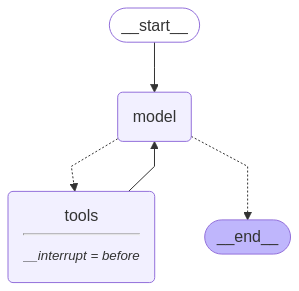

In [21]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [22]:
config = {
    "configurable": {
        "thread_id": "1"
        }   
    }

In [23]:
events = app.stream({
    "messages": [HumanMessage(content="What is the current weather in Islamabad, Pakistan?")]
}, config=config, stream_mode="values")

for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is the current weather in Islamabad, Pakistan?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_kwyb)
 Call ID: call_kwyb
  Args:
    query: current weather in Islamabad, Pakistan


In [24]:
snapshot = app.get_state(config=config)
snapshot.next

('tools',)

In [26]:
events = app.stream(None, config, stream_mode="values")
for event in events:
    event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_kwyb)
 Call ID: call_kwyb
  Args:
    query: current weather in Islamabad, Pakistan
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.easeweather.com/asia/pakistan/islamabad/april", "content": "So far, April 2025 in Islamabad shows a warmer trend than usual by 3.1 °C. The forecast for the next days in Islamabad predicts a temperature of 38.1 °C, which"}, {"url": "https://www.timeanddate.com/weather/pakistan/islamabad/ext", "content": "106 / 79 °F, Sunny. 104 °F, 7 mph, ↑, 17%, 4%, -, 7 (High), 5:05 am, 7:03 pm ... * Updated Sunday, May 4, 2025 2:24:04 am Islamabad time - Weather by"}]
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_5st3)
 Call ID: call_5st3
  Args:
    query: current weather Isla